# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо Ппостроить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Импорт библиотек

In [38]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import phik
import plotly.express as px

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set(rc={'figure.figsize': (20, 10)})

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Вспомогательные функции

In [39]:
def transform_columns_values(df):
    '''
    Функция приводит значения колонок и значений к единому формату
    Заменяет пробелы на _, приводит к нижнему регистру
    Проверяет явные дубли и пропущенные значения
    '''
    df.columns = df.columns.str.replace(' ', '_', regex=True).str.lower()
    object_columns = df.select_dtypes('object').columns
    df[object_columns] = df.select_dtypes('object').apply(
        lambda x: x.str.replace(' ', '_', regex=True).str.lower()
    )
    # Обработка дублей
    print(f'''Дубли в индексах: {df.index.duplicated().sum()}''')
    df = df.reset_index().drop_duplicates(subset='id').set_index('id')
    print(
        f'''Дубли в индексах после обработки: {df.index.duplicated().sum()}'''
    )
    print(f'''Явных дублей: {df.duplicated().sum()}\n\n''')

    # Обработка пропущенных значений
    print('Пропущенных значений:\n')
    display(
        (
            pd.DataFrame(
                round(df.isna().mean() * 100, 1).sort_values(ascending=False)
            ).style.background_gradient('coolwarm')
        )
    )

    display(df.info())
    print('\n')
    display(df.describe())
    display(df.head())

    return df

In [40]:
def plot_numeric(df, variable, title, xlabel, bins):
    '''Рисует графики распределения количественных переменных'''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    f.suptitle(title, fontsize=20)
    ax1.boxplot(df[variable])
    ax1.set_title('Ящик с усами')
    ax1.set_xlabel(xlabel)
    ax1.set_xticks([])

    ax2.hist(df[variable], bins=bins)
    ax2.set_title('Гистограмма')
    ax2.set_xlabel(xlabel)

    plt.show()

## Загрузка и подготовка данных

In [41]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv', index_col=0)
geo_1 = pd.read_csv('/datasets/geo_data_1.csv', index_col=0)
geo_2 = pd.read_csv('/datasets/geo_data_2.csv', index_col=0)

In [42]:
geo_0 = transform_columns_values(geo_0)

Дубли в индексах: 10
Дубли в индексах после обработки: 0
Явных дублей: 0


Пропущенных значений:



,0
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


<class 'pandas.core.frame.DataFrame'>
Index: 99990 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99990 non-null  float64
 1   f1       99990 non-null  float64
 2   f2       99990 non-null  float64
 3   product  99990 non-null  float64
dtypes: float64(4)
memory usage: 5.8+ MB


None

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [43]:
geo_1 = transform_columns_values(geo_1)

Дубли в индексах: 4
Дубли в индексах после обработки: 0
Явных дублей: 0


Пропущенных значений:



,0
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 5.8+ MB


None

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


In [44]:
geo_2 = transform_columns_values(geo_2)

Дубли в индексах: 4
Дубли в индексах после обработки: 0
Явных дублей: 0


Пропущенных значений:



,0
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 5.8+ MB


None

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


## Исследовательский анализ данных

### geo_0

##### Распределения и выбросы

Проверим непрерывные переменные на предмет выбросов с помощью вычисления z-значения.

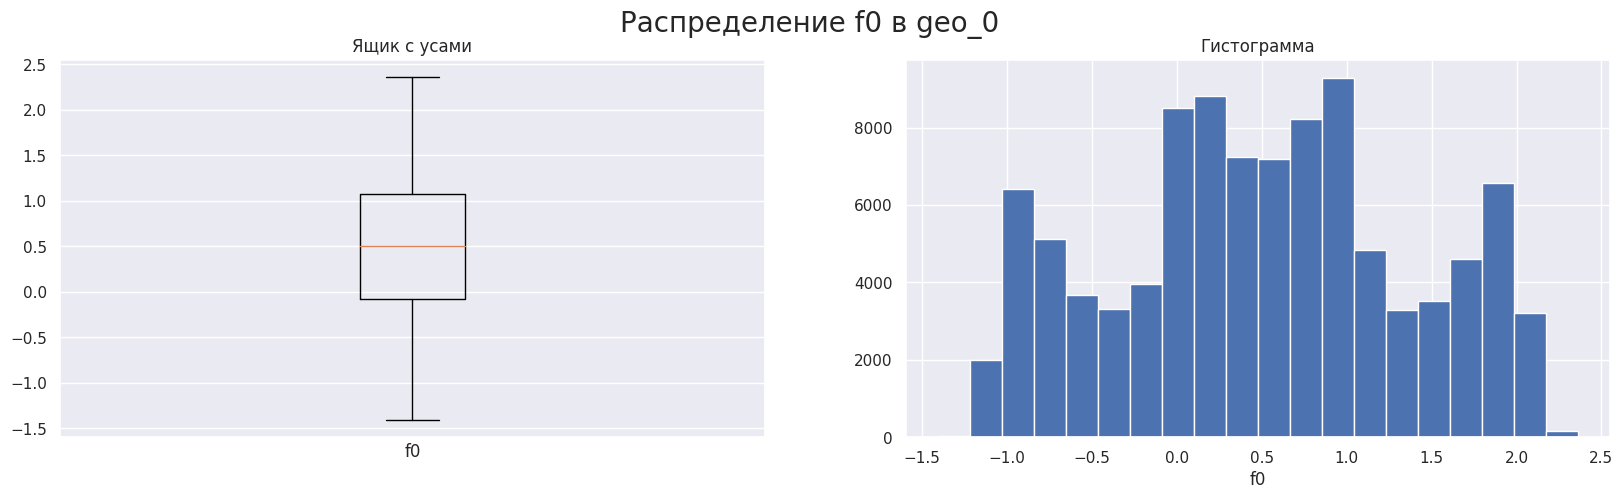

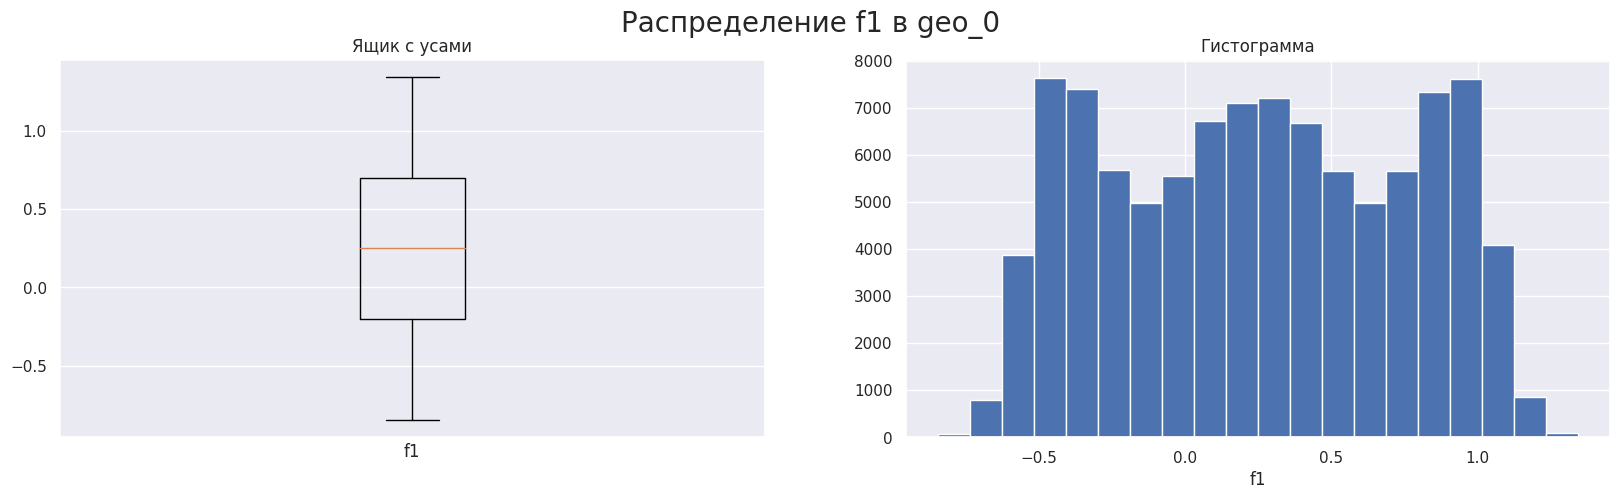

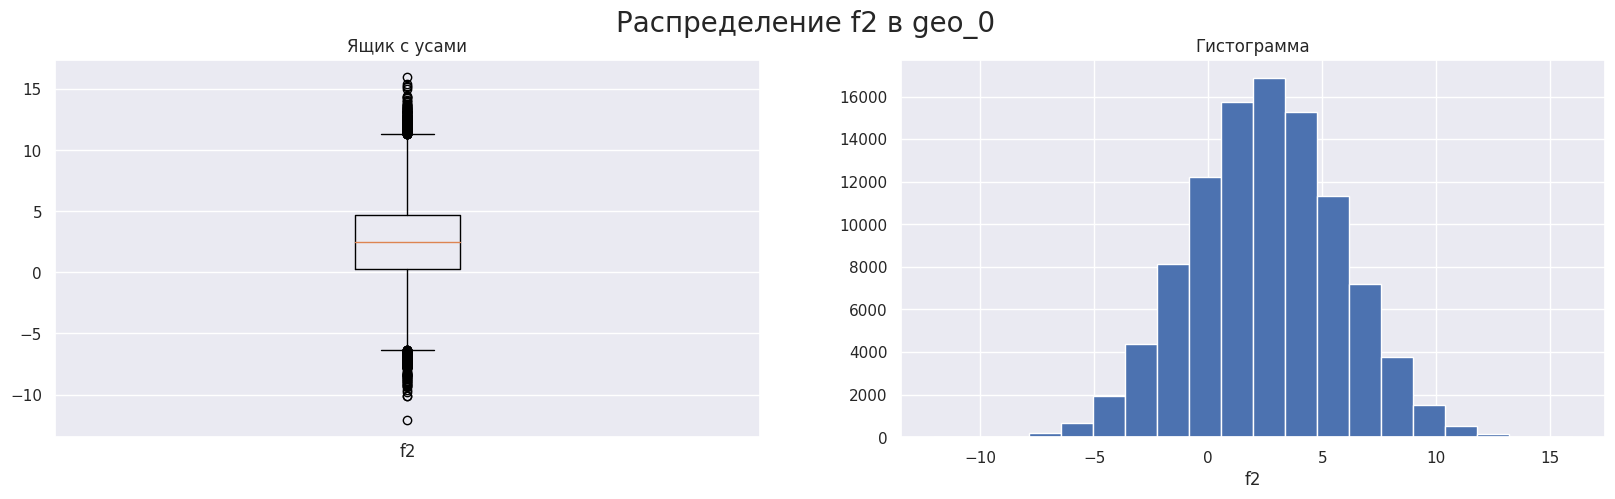

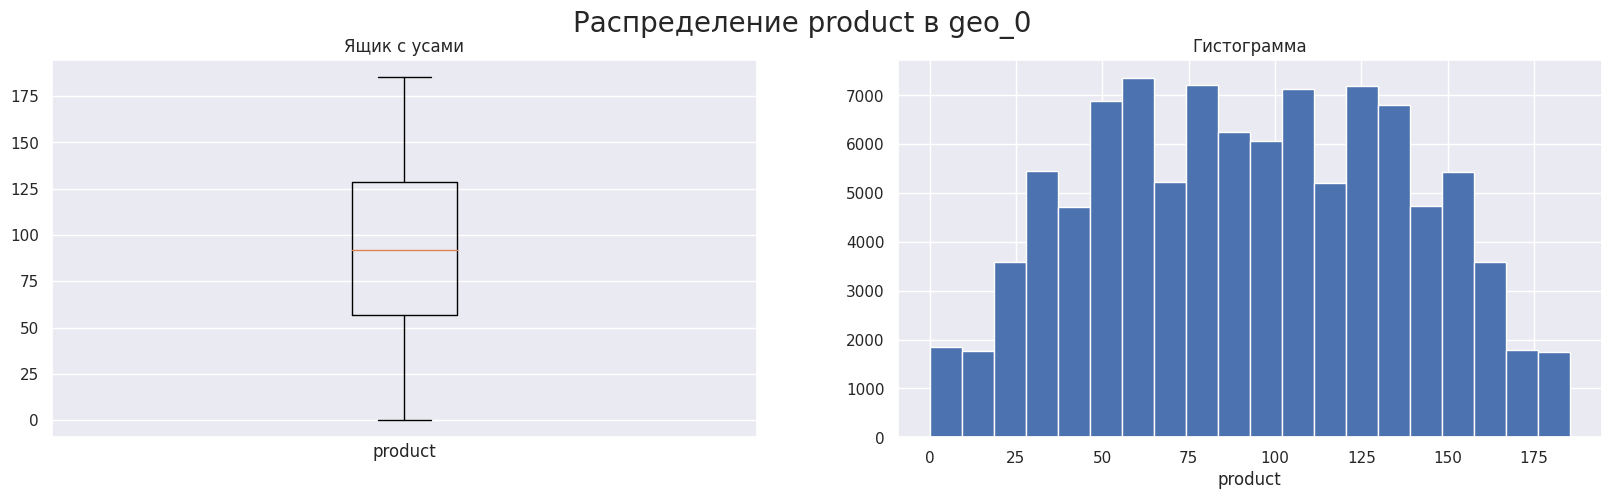

In [45]:
for column in ['f0', 'f1', 'f2', 'product']:
    plot_numeric(geo_0, column, f'Распределение {column} в geo_0', column, 20)

In [46]:
# Аномальные значения в регионе geo_0
for column in ['f0', 'f1', 'f2', 'product']:
    anomal = geo_0[np.abs(stats.zscore(geo_0[column])) >= 3]
    print(f'''Аномальных значений {column} в регионе geo_0: {len(anomal)}''')
    anomal.head()

Аномальных значений f0 в регионе geo_0: 0
Аномальных значений f1 в регионе geo_0: 0
Аномальных значений f2 в регионе geo_0: 178
Аномальных значений product в регионе geo_0: 0


Переменные f0 и f1 распределены ненормально - они имеют по 3 пика. Переменная f2 распределена нормально, но имеет выбросы. Мы не можем быть уверены, что выбросы нужно удалять, потому что нам неизвестен смысл переменной.

#### Корреляционный анализ

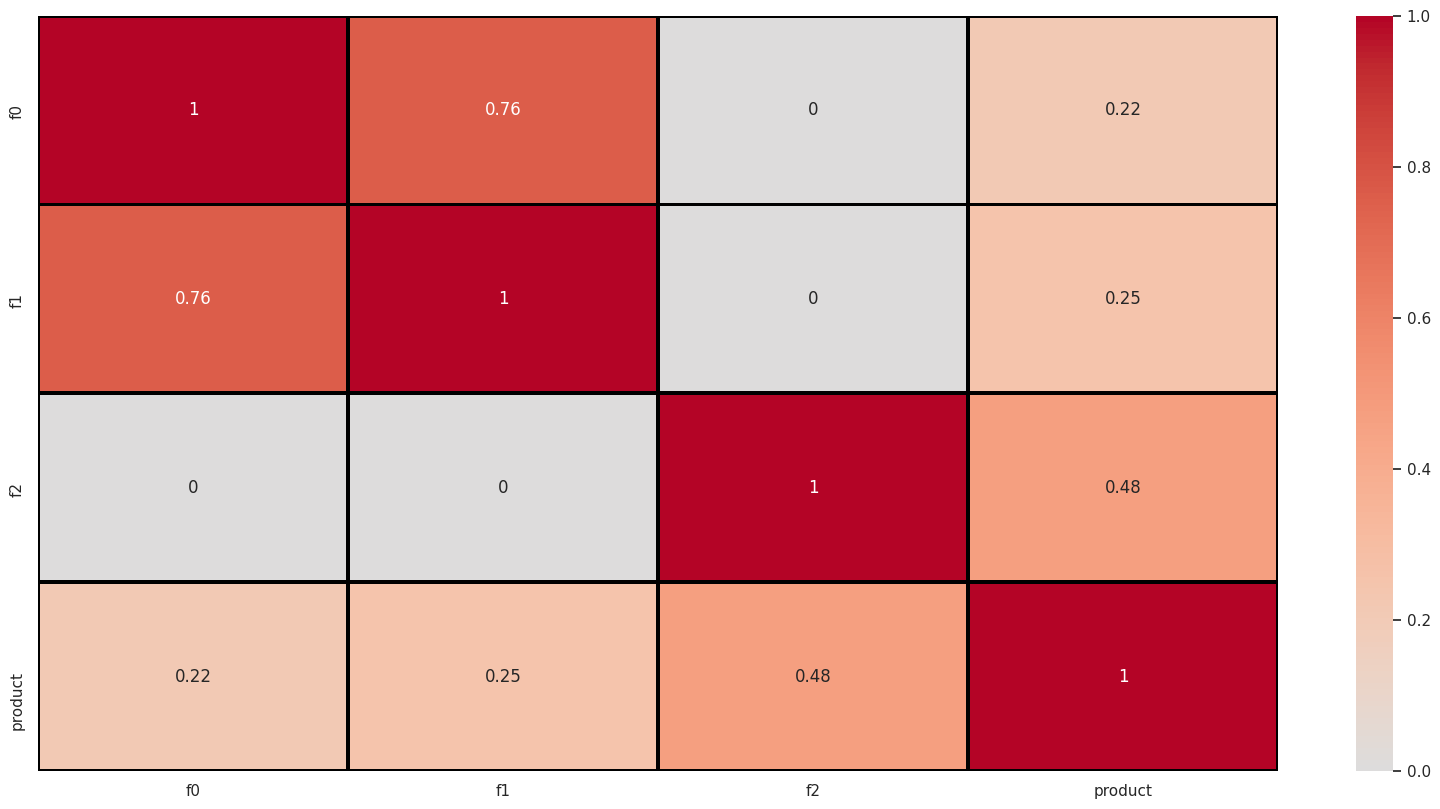

In [47]:
plt.figure(figsize=(20, 10))
sns.heatmap(
    geo_0.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']),
    cmap='coolwarm',
    center=0,
    annot=True,
    linewidths=2,
    linecolor='black',
)

f0 и f1 имеют достаточно высокую корреляцию, но недостаточно высокую, чтобы отбросить одну из них

### geo_1

#### Распределения и выбросы

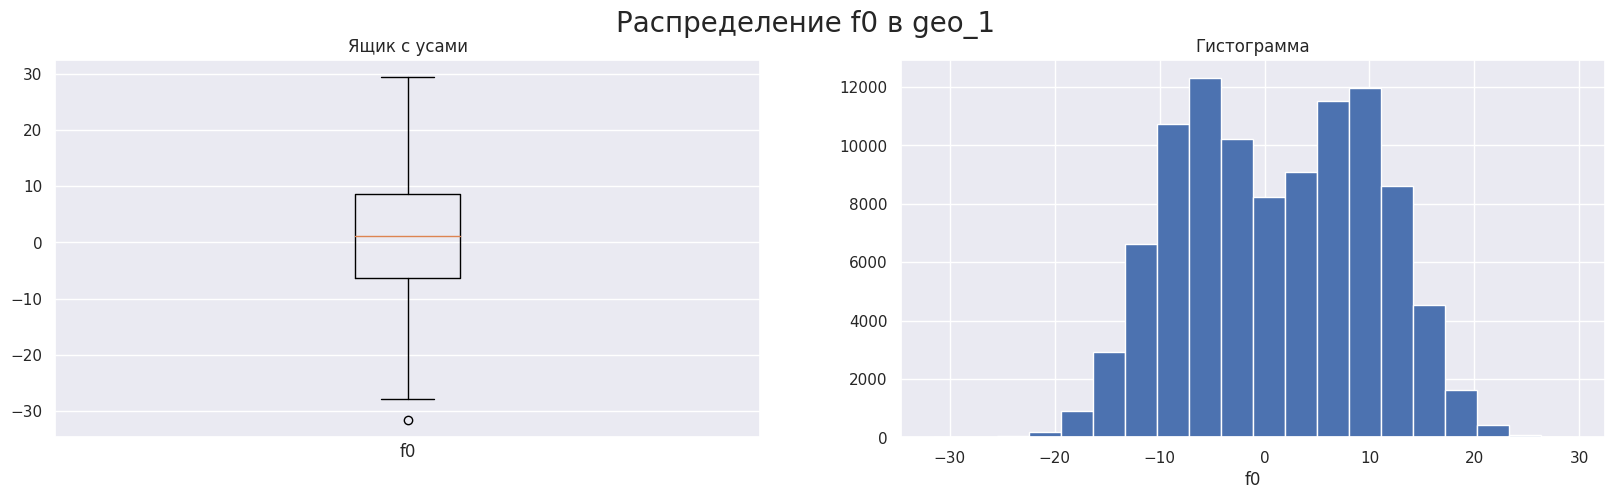

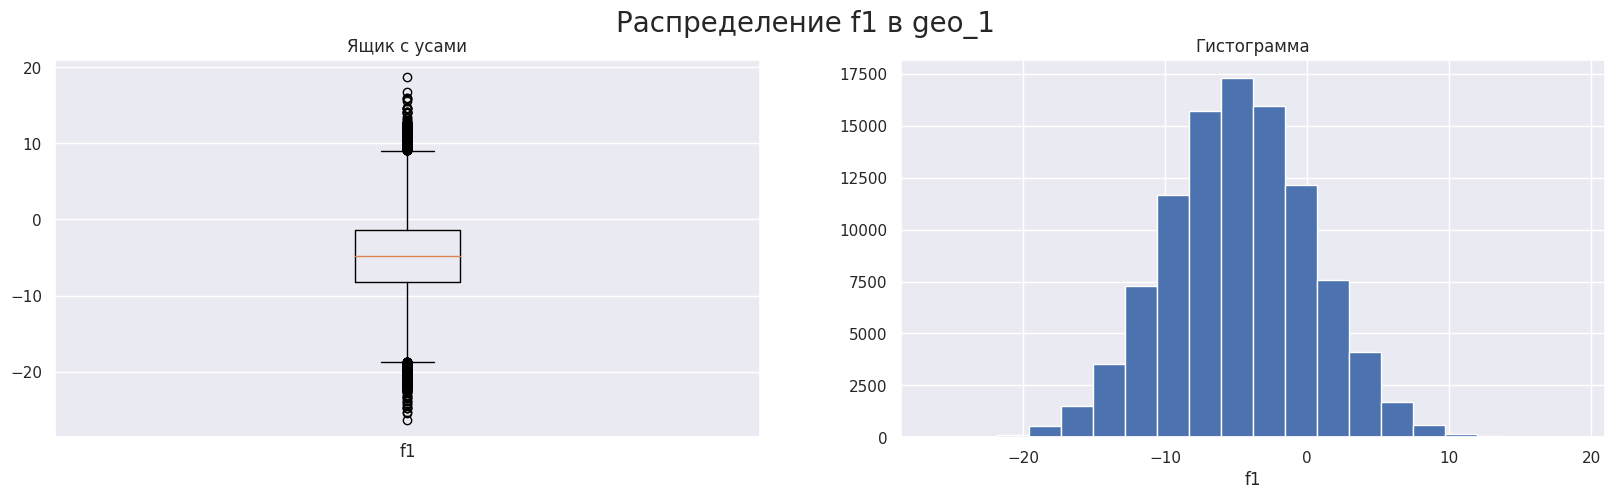

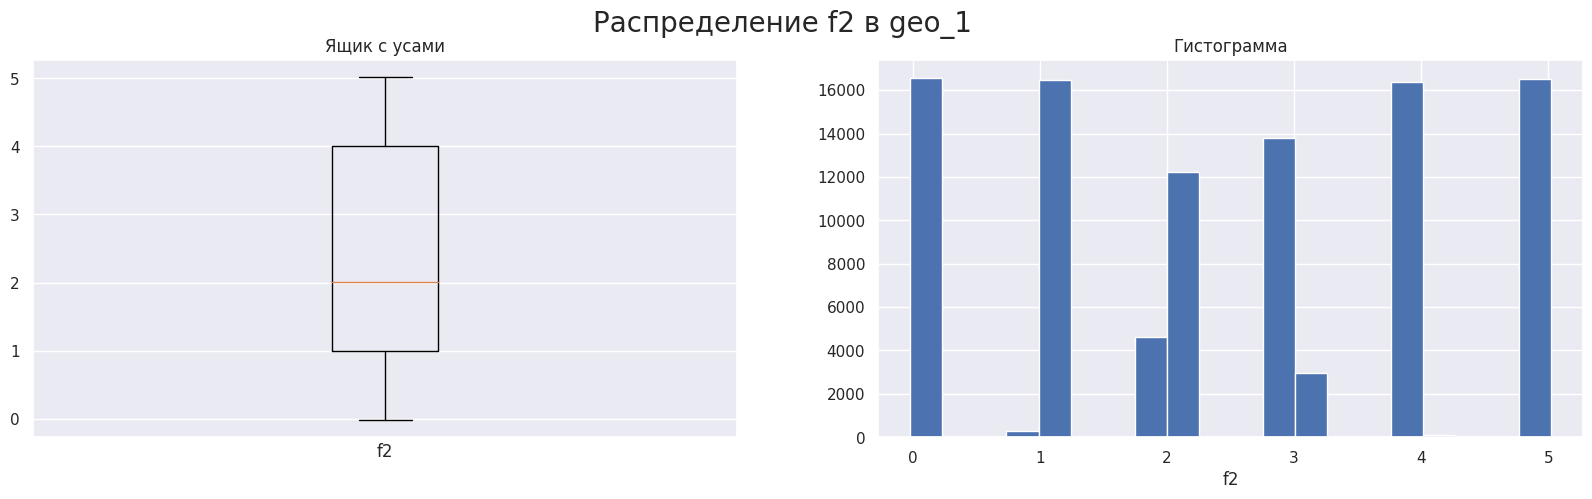

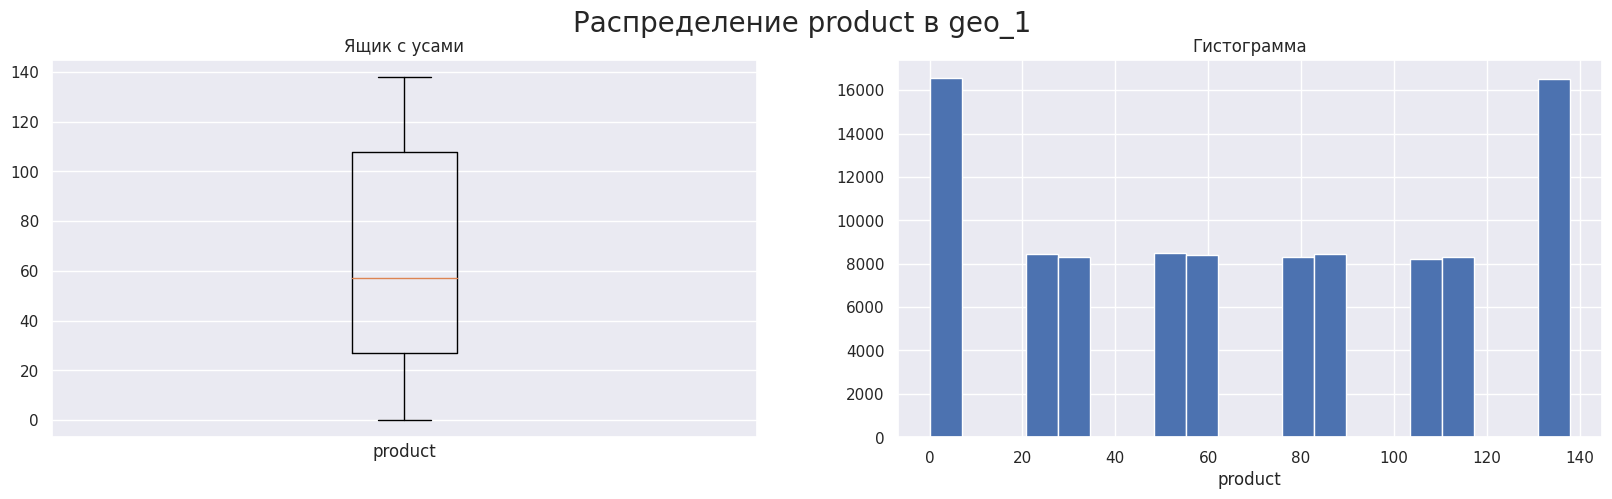

In [48]:
for column in ['f0', 'f1', 'f2', 'product']:
    plot_numeric(geo_1, column, f'Распределение {column} в geo_1', column, 20)

In [49]:
# Аномальные значения в регионе geo_1
for column in ['f0', 'f1', 'f2']:
    anomal = geo_1[np.abs(stats.zscore(geo_1[column])) >= 3]
    print(f'''Аномальных значений {column} в регионе geo_1: {len(anomal)}''')
    anomal.head()

Аномальных значений f0 в регионе geo_1: 7
Аномальных значений f1 в регионе geo_1: 262
Аномальных значений f2 в регионе geo_1: 0


Распределения в geo_1 еще более необычные, чем в geo_0. f1 распределен нормально с некоторым количеством выбросов, что очень похоже на распределение f2 в geo_0. Возможно, это один и тот же показатель.

#### Корреляционный анализ

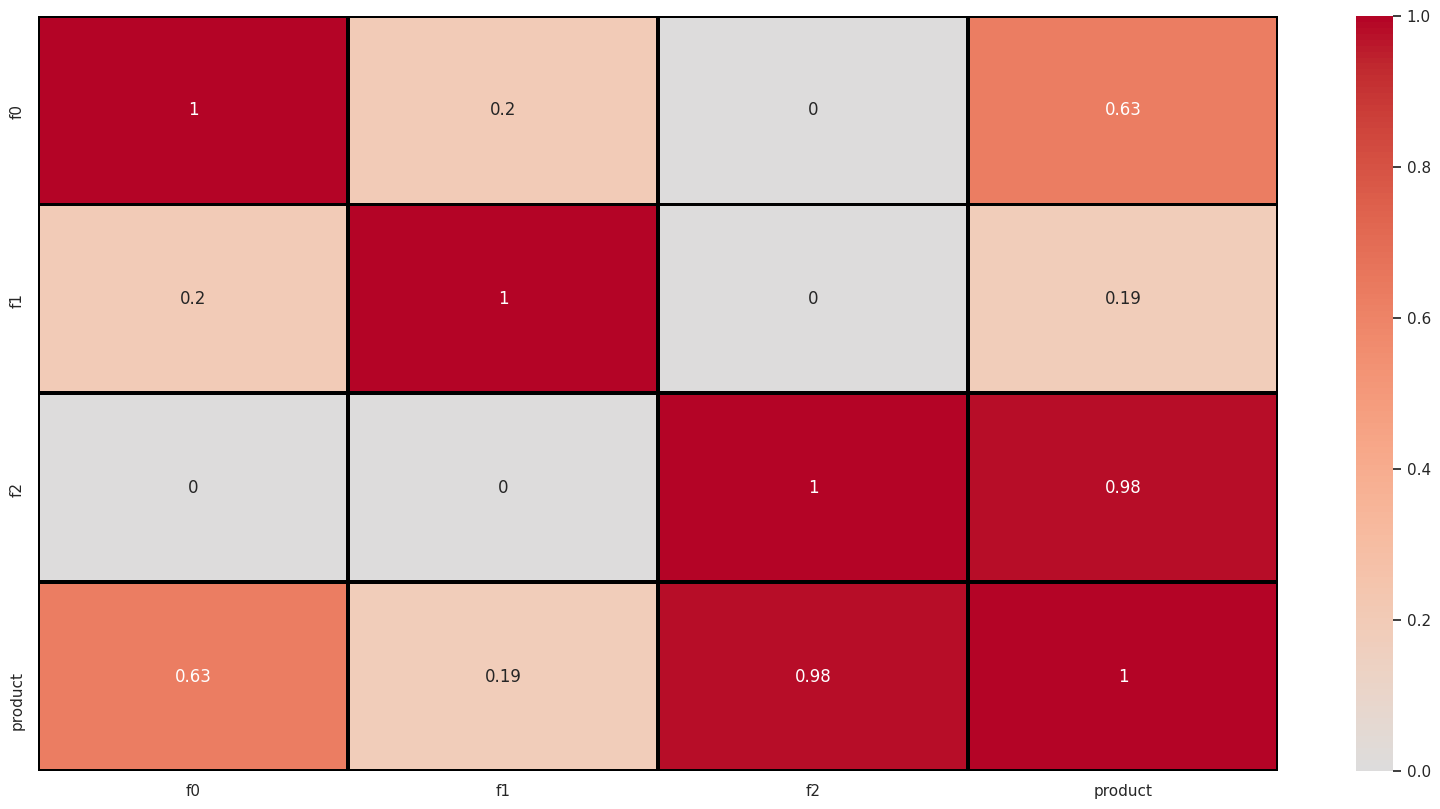

In [50]:
plt.figure(figsize=(20, 10))
sns.heatmap(
    geo_1.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']),
    cmap='coolwarm',
    center=0,
    annot=True,
    linewidths=2,
    linecolor='black',
)

f2 почти идентичен целевой переменной. Возможно, лишь одного него будет достаточно, чтобы построить хорошую модель. Это предстоит проверить.

### geo_2

#### Распределения и выбросы

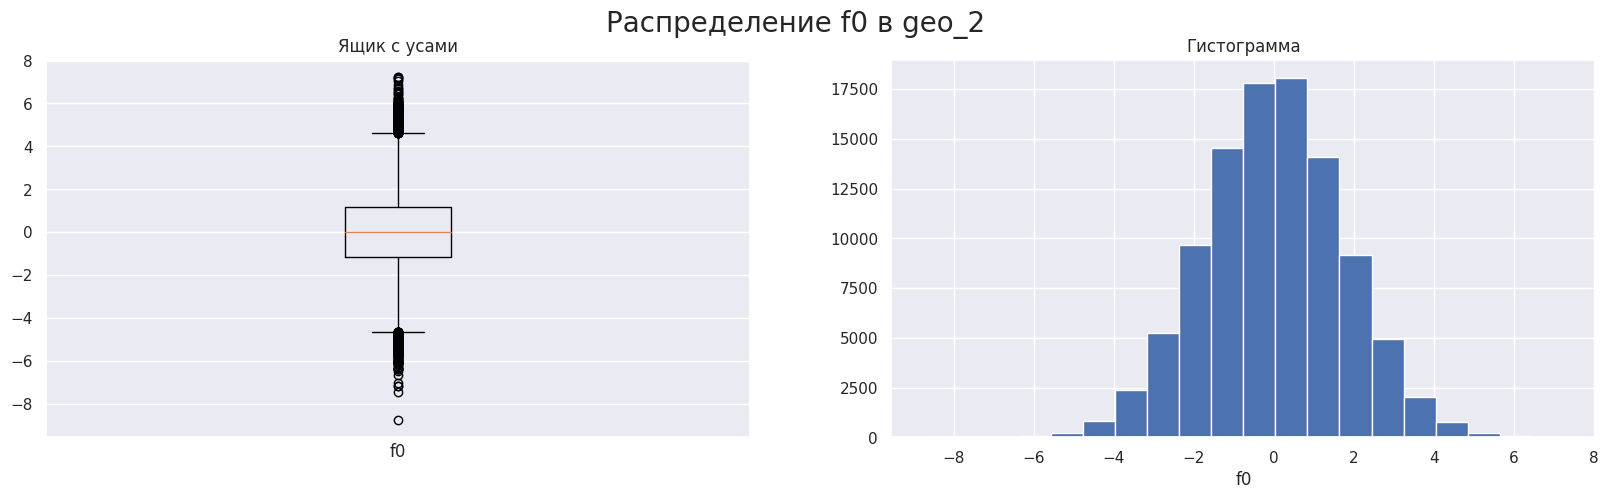

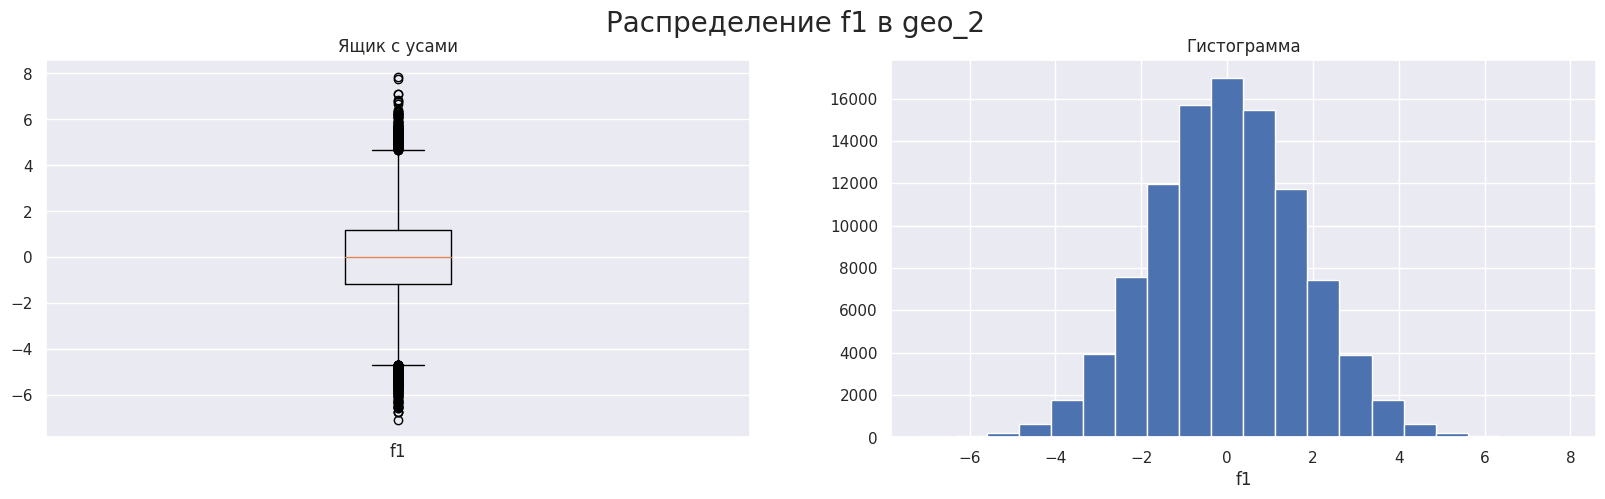

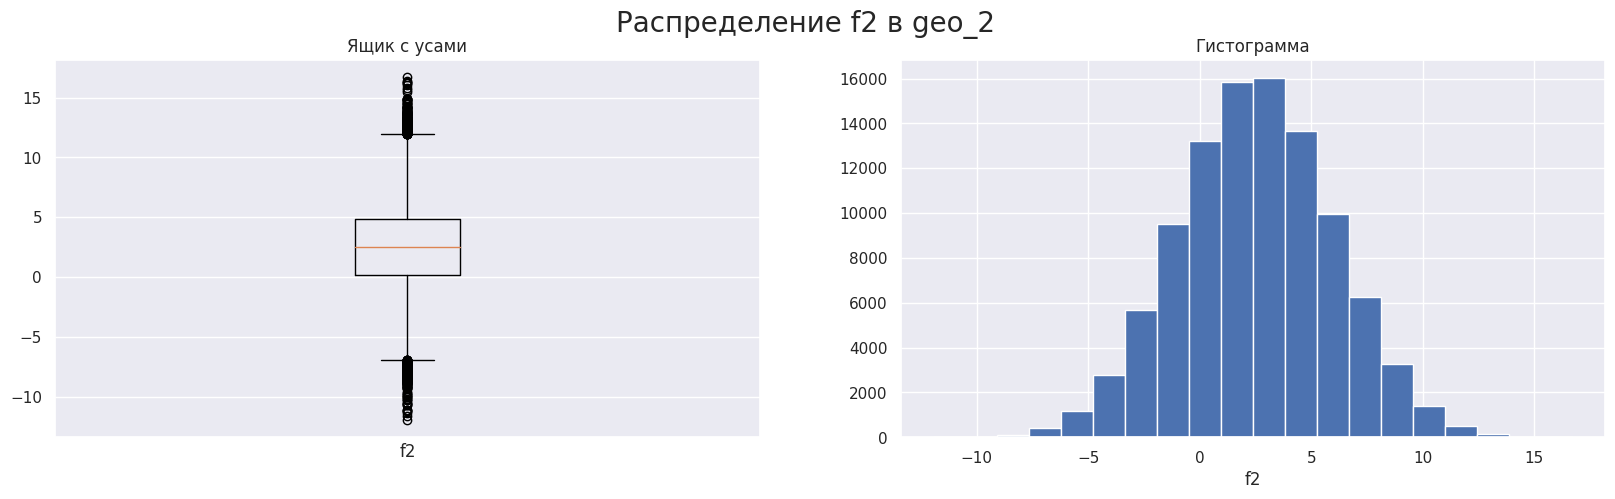

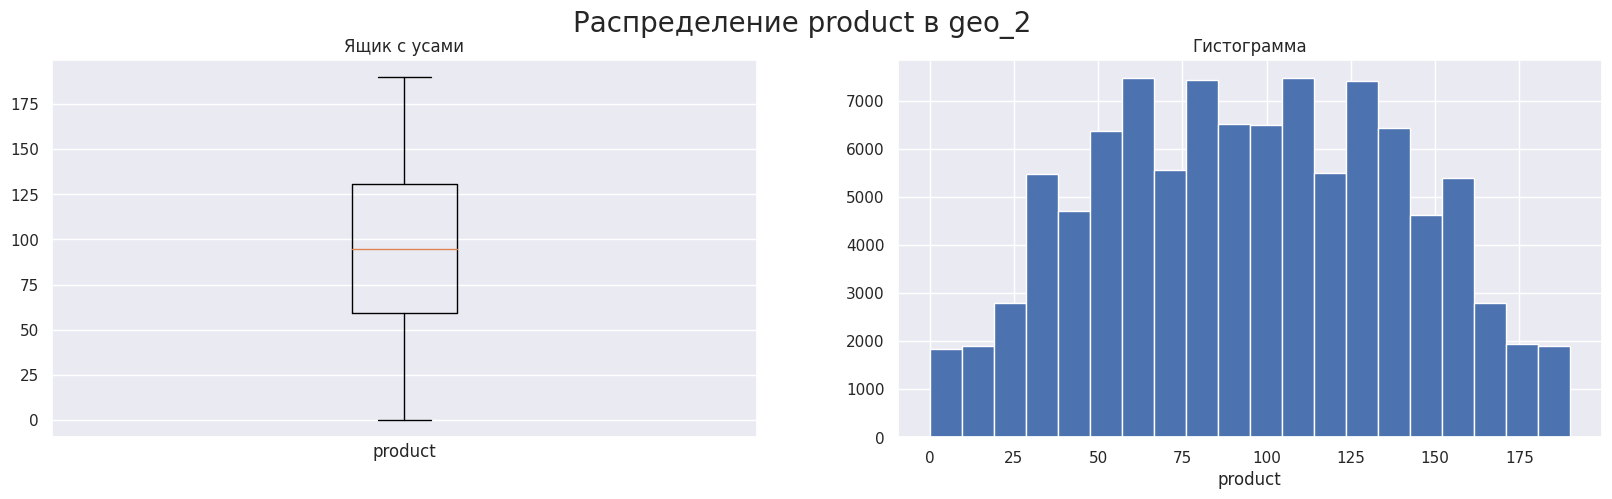

In [51]:
for column in ['f0', 'f1', 'f2', 'product']:
    plot_numeric(geo_2, column, f'Распределение {column} в geo_2', column, 20)

In [52]:
# Аномальные значения в регионе geo_2
for column in ['f0', 'f1', 'f2']:
    anomal = geo_2[np.abs(stats.zscore(geo_2[column])) >= 3]
    print(f'''Аномальных значений {column} в регионе geo_02: {len(anomal)}''')
    anomal.head()

Аномальных значений f0 в регионе geo_02: 266
Аномальных значений f1 в регионе geo_02: 281
Аномальных значений f2 в регионе geo_02: 200


В geo_2 все независимые переменные распределены нормально и имеют выбросы.

#### Корреляционный анализ

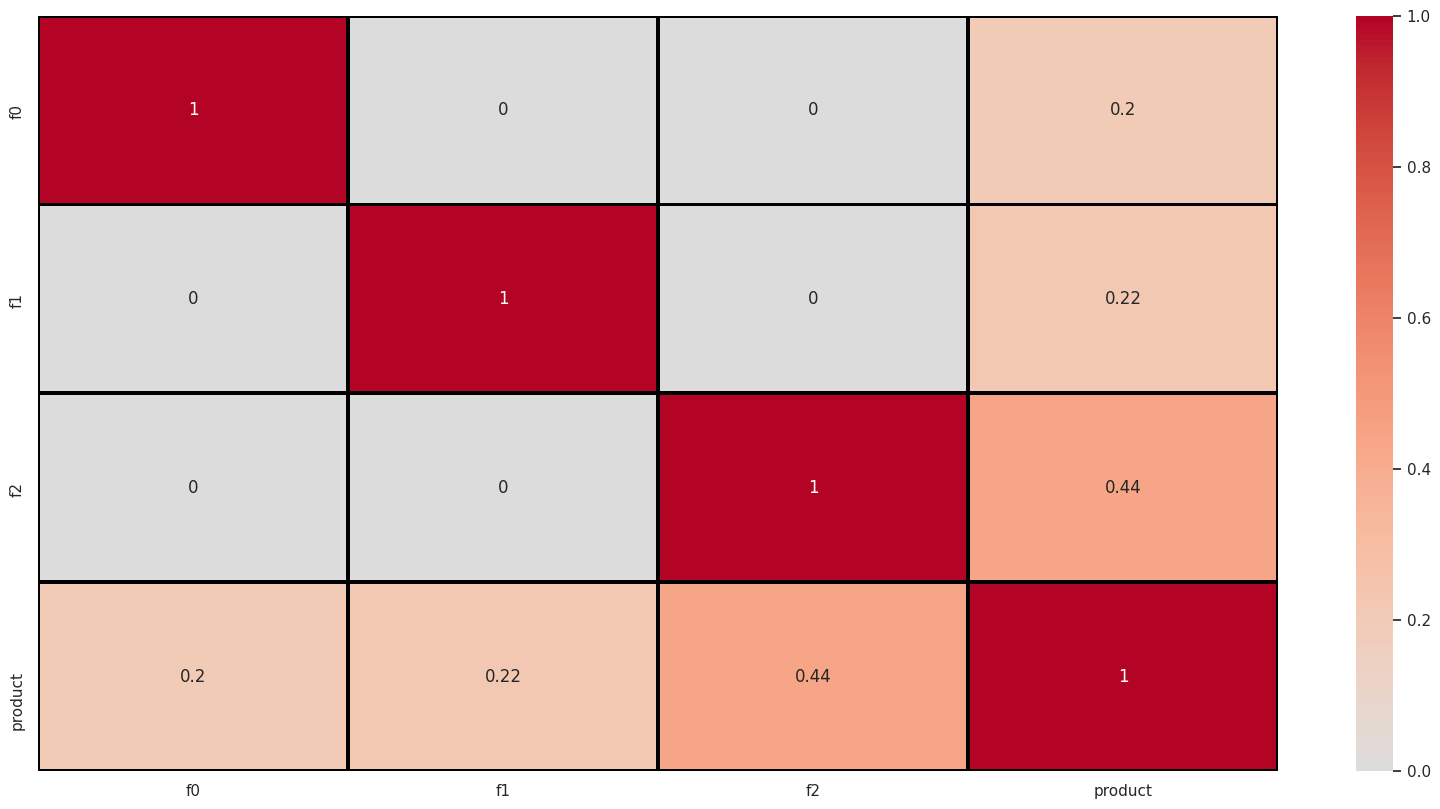

In [53]:
plt.figure(figsize=(20, 10))
sns.heatmap(
    geo_2.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']),
    cmap='coolwarm',
    center=0,
    annot=True,
    linewidths=2,
    linecolor='black',
)

Данные в трех регионах сильно различаются. Нам нужно будет обучить три разных модели по одной для каждого региона.

## Обучение и проверка модели

Для всех моделей нам нужен идентичный порядок действий. Будет удобно описать функцию, которую мы будем применять для всех датасетов.

In [54]:
def oil_linear_model(df):
    '''
    Обучает модель делает предсказания.
    Печатает RMSE на тренировочной и тестовой выборках.
    Возвращает обученную модель и предсказания по валидационной выборке.
    '''
    X = df.drop('product', axis=1)
    y = df['product']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    scaler = StandardScaler()

    # Стандартизация train
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(
        X_train_scaled, columns=X_train.columns, index=X_train.index
    )

    # Стандартизация test

    X_val_scaled = scaler.transform(X_val)
    X_val = pd.DataFrame(
        X_val_scaled, columns=X_val.columns, index=X_val.index
    )

    # Обучение модели
    linear = LinearRegression()
    linear.fit(X_train, y_train)

    predict_train = linear.predict(X_train)

    # Собираем полную выборку
    predict_total = linear.predict(X)
    total_df = X.merge(y, left_index=True, right_index=True)
    total_df['product_predicted'] = predict_total

    # Собираем валидационную выборку

    predict_val = linear.predict(X_val)
    val_df = X_val.merge(y_val, left_index=True, right_index=True)
    val_df['product_predicted'] = predict_val

    # RMSE на тренировочной выборке
    train_score = np.sqrt(mean_squared_error(y_train, predict_train))
    # RMSE на тестовой выборке
    val_score = np.sqrt(mean_squared_error(y_val, predict_val))

    print(f'''RMSE на тренировочной выборке: {train_score}''')
    print(f'''RMSE на валидационной выборке: {val_score}''')
    print(f'''Средний запас предсказанного сырья: {predict_total.mean()}''')

    return linear, total_df, val_df

### geo_0

In [55]:
linear_0, geo_0, geo_0_pred = oil_linear_model(geo_0)

RMSE на тренировочной выборке: 37.69478548062988
RMSE на валидационной выборке: 37.68508926201444
Средний запас предсказанного сырья: 145.99905031814467


### geo_1

In [56]:
linear_1, geo_1, geo_1_pred = oil_linear_model(geo_1)

RMSE на тренировочной выборке: 0.8895714959041909
RMSE на валидационной выборке: 0.8928265978121422
Средний запас предсказанного сырья: 182.47465854043904


### geo_2

In [57]:
linear_2, geo_2, geo_2_pred = oil_linear_model(geo_2)

RMSE на тренировочной выборке: 40.046602415967584
RMSE на валидационной выборке: 40.080822438088305
Средний запас предсказанного сырья: 144.88480057520331


### Промежуточный вывод

- Лучше всех показал себя датасет geo_1, поскольку там присутствовала переменная, практически совпадающая с целевой. Если мы предполагаем, что можно раздобыть аналогичные данные в регионах geo_0 и geo_2, у нас получатся отличные прогнозы и по ним тоже.
- Можно увидеть, что чем меньше RMSE, тем больше объем предсказанного сырья.

## Подготовка к расчёту прибыли

In [58]:
# Прибыль с единицы продукта
BARREL_REVENUE = 450
PRODUCT_REVENUE = BARREL_REVENUE * 1000

# Стоимость разработки двухсот лучших скважин
OIL_WELL_COST = 10_000_000_000
TOP_WELLS_AMOUNT = 200

# Граница вероятности убыточности
THRESHOLD = 0.025

# Безубыточный средний объем среди двухсот скважин
NON_LOSS_PRODUCT_AMOUNT = OIL_WELL_COST / PRODUCT_REVENUE
TOP_200_WELLS_AMOUNT = round(NON_LOSS_PRODUCT_AMOUNT / TOP_WELLS_AMOUNT) + 1
print(f'Объем безубыточного производства: {TOP_200_WELLS_AMOUNT}')

Объем безубыточного производства: 112


In [59]:
geo_num = 0
for geo in [geo_0, geo_1, geo_2]:
    geo_mean = geo['product'].mean()
    print(f'Средний объем в регионе geo_{geo_num}: {geo_mean}')
    print(f'Отличается от целевого на: {geo_mean - top_200_wells_amount}\n')
    geo_num += 1

Средний объем в регионе geo_0: 92.49968421774354
Отличается от целевого на: -19.500315782256465

Средний объем в регионе geo_1: 68.82391591804064
Отличается от целевого на: -43.17608408195936

Средний объем в регионе geo_2: 94.99834211933378
Отличается от целевого на: -17.001657880666215



### Промежуточный вывод

Средний объем сырья в каждом регионе меньше целевого, поэтому нам нужно тщательно отобрать 200 точек, которые мы будем рекомендовать к разработке.

## Расчёт прибыли и рисков 

In [60]:
def profit_calc(df, top_amount, product_revenue, oil_well_cost):
    '''
    Функция для расчета прибыли в регионе.
    df - датасет с объемом сырья
    top_amount - сколько скважин хотим посчитать
    product_revenue - доход с единицы продукта
    oil_well_cost - стоимость разработки в регионе
    '''
    top_200_pred = df.sort_values('product_predicted', ascending=False).iloc[
        :top_amount
    ]
    top_200_product = top_200_pred['product'].sum()
    return top_200_product * product_revenue - oil_well_cost

In [61]:
geo_num = 0
for geo in [geo_0, geo_1, geo_2]:
    profit = profit_calc(geo, 200, PRODUCT_REVENUE, OIL_WELL_COST)
    print(
        f'Прогнозируемая прибыль с лучших 200 скважин в регионе geo_{geo_num}: {profit}'
    )
    geo_num += 1

Прогнозируемая прибыль с лучших 200 скважин в регионе geo_0: 2948960411.773096
Прогнозируемая прибыль с лучших 200 скважин в регионе geo_1: 2415086696.681511
Прогнозируемая прибыль с лучших 200 скважин в регионе geo_2: 2583659790.712284


### Прибыли и риски для каждого региона

In [66]:
state = np.random.RandomState(RANDOM_STATE)


def estimated_profit(df, geo_num):
    bootstrap_values = []
    for i in range(1000):
        subsample = df.sample(500, replace=True, random_state=state)
        bootstrap_values.append(
            profit_calc(subsample, 200, PRODUCT_REVENUE, OIL_WELL_COST)
        )
    bootstrap_values = pd.Series(bootstrap_values)

    # Расчет метрик
    average_profit = round(bootstrap_values.mean())
    quant_high = round(np.quantile(bootstrap_values, 0.975))
    quant_low = round(np.quantile(bootstrap_values, 0.025))

    # Вывод
    print(f'geo_{geo_num}')
    print(f'Средняя ожидаемая прибыль в регионе:      {average_profit}')
    print(f'Минимальная ожидаемая прибыль в регионе:  {quant_low}')
    print(f'Максимальная ожидаемая прибыль в регионе: {quant_high}\n')

In [68]:
geo_num = 0
for geo in [geo_0_pred, geo_1_pred, geo_2_pred]:
    estimated_profit(geo, geo_num)
    geo_num += 1

geo_0
Средняя ожидаемая прибыль в регионе:      418755929
Минимальная ожидаемая прибыль в регионе:  -64013593
Максимальная ожидаемая прибыль в регионе: 898298106

geo_1
Средняя ожидаемая прибыль в регионе:      432886180
Минимальная ожидаемая прибыль в регионе:  17497718
Максимальная ожидаемая прибыль в регионе: 830225618

geo_2
Средняя ожидаемая прибыль в регионе:      366703212
Минимальная ожидаемая прибыль в регионе:  -120332584
Максимальная ожидаемая прибыль в регионе: 872509639



### Промежуточный вывод

Стоит начать разработку в регионе geo_1, поскольку именно в нём самая высокая средняя оценка прибыли, а также минимальная ожидаемая оценка тоже не убыточна, в отличии от двух других регионов.

## Общий вывод

**Перед нами стояла задача:**

Определить регион, где стоит начать разработку новых месторождений.

**Что мы сделали:**

<ol>
    <li>
        Проверили данные на предмет пропущенных значений и дубликатов:
        <ul>
            <li>Пропущенных значений не было обнаружено</li>
            <li>Некоторые скважины попали в датасет несколько раз. Мы удалили их, чтобы не навредить будущей модели</li>
        </ul>
    </li>
    <li>
        Провели исследовательский анализ данных:
        <ul>
            <li>Обнаружили выбросы, но оставили их. Решение об удалении следовало бы принять со специалистом со стороны бизнеса</li>
            <li>Визуально оценили распределения данных. В разных регионах были зашифрованы разные признаки</li>
            <li>В регионе geo_1 обнаружили признак, очень похожий на зависимую переменную</li>
        </ul>
    </li>
    <li>
        Провели корреляционный анализ:
        <ul>
            <li>Мультиколлинеартности не было обнаружено</li>
            <li>В регионе geo_1 действительно обнаружился признак, почти полностью объясняющий целевую переменную</li>
        </ul>
    </li>
    <li>
        Обучили три модели машинного обучения - по подной для каждого региона
    </li>
    <li>
        Создали функцию расчета ожидаемой прибыли
    </li>
    <li>
        С помощью техники *bootstrap* смоделировали ситуацию разработки новых месторождений в регионе и оценили возможную прибыль
    </li>
    <li>
        Выбрали лучший регион для разработки
    </li>
</ol>

**Рекомендации для бизнеса:**
<ul>
    <li>
        Начать разработку в регионе *geo_1*, несмотря на то, что средняя прибыль двухсот уже разработанных вышек кажется ниже, чем в регионах *geo_0* и *geo_2*
    </li>
    <li>
        Обеспечить данные из других регионов признаком *f2* региона *geo_1*. Он почти полностью объясняет целевую переменную. Возможно, картина вновь изменится, если мы будем обладать им на всех трех датасетах
    </li>
</ul>